https://scikit-learn.org/stable/auto_examples/preprocessing/plot_target_encoder.html#sphx-glr-auto-examples-preprocessing-plot-target-encoder-py


# Comparing Target Encoder with Other Encoders

.. currentmodule:: sklearn.preprocessing

The :class:`TargetEncoder` uses the value of the target to encode each
categorical feature. In this example, we will compare three different approaches
for handling categorical features: :class:`TargetEncoder`,
:class:`OrdinalEncoder`, :class:`OneHotEncoder` and dropping the category.

<div class="alert alert-info"><h4>Note</h4><p>`fit(X, y).transform(X)` does not equal `fit_transform(X, y)` because a
    cross fitting scheme is used in `fit_transform` for encoding. See the
    `User Guide <target_encoder>`. for details.</p></div>


## Loading Data from OpenML
First, we load the wine reviews dataset, where the target is the points given
be a reviewer:



In [1]:
from sklearn.datasets import fetch_openml

wine_reviews = fetch_openml(data_id=42074, as_frame=True, parser="pandas")

df = wine_reviews.frame
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


For this example, we use the following subset of numerical and categorical
features in the data. The target are continuous values from 80 to 100:



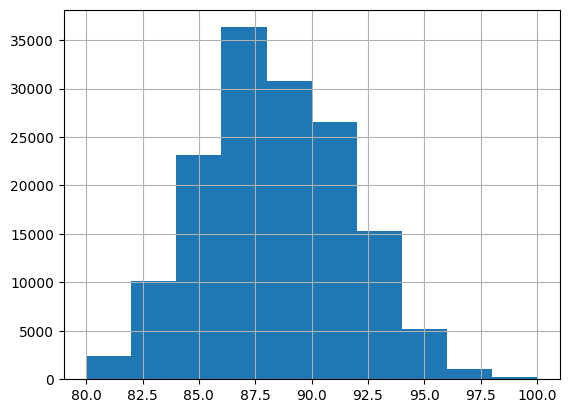

In [2]:
numerical_features = ["price"]
categorical_features = [
    "country",
    "province",
    "region_1",
    "region_2",
    "variety",
    "winery",
]
target_name = "points"

X = df[numerical_features + categorical_features]
y = df[target_name]

_ = y.hist()

## Training and Evaluating Pipelines with Different Encoders
In this section, we will evaluate pipelines with
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` with different encoding
strategies. First, we list out the encoders we will be using to preprocess
the categorical features:



In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

Next, we evaluate the models using cross validation and record the results:



In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

n_cv_folds = 3
max_iter = 20
results = []


def evaluate_model_and_store(name, pipe):
    result = cross_validate(
        pipe,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=n_cv_folds,
        return_train_score=True,
    )
    rmse_test_score = -result["test_score"]
    rmse_train_score = -result["train_score"]
    results.append(
        {
            "preprocessor": name,
            "rmse_test_mean": rmse_test_score.mean(),
            "rmse_test_std": rmse_train_score.std(),
            "rmse_train_mean": rmse_train_score.mean(),
            "rmse_train_std": rmse_train_score.std(),
        }
    )


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state=0, max_iter=max_iter)
    )
    evaluate_model_and_store(name, pipe)

## Native Categorical Feature Support
In this section, we build and evaluate a pipeline that uses native categorical
feature support in :class:`~sklearn.ensemble.HistGradientBoostingRegressor`,
which only supports up to 255 unique categories. In our dataset, the most of
the categorical features have more than 255 unique categories:



In [5]:
n_unique_categories = df[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories

winery      14810
region_1     1236
variety       632
province      455
country        48
region_2       18
dtype: int64

To workaround the limitation above, we group the categorical features into
low cardinality and high cardinality features. The high cardinality features
will be target encoded and the low cardinality features will use the native
categorical feature in gradient boosting.



In [6]:
high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "high_cardinality",
            TargetEncoder(target_type="continuous"),
            high_cardinality_features,
        ),
        (
            "low_cardinality",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            low_cardinality_features,
        ),
    ],
    verbose_feature_names_out=False,
)

# The output of the of the preprocessor must be set to pandas so the
# gradient boosting model can detect the low cardinality features.
mixed_encoded_preprocessor.set_output(transform="pandas")
mixed_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    HistGradientBoostingRegressor(
        random_state=0, max_iter=max_iter, categorical_features=low_cardinality_features
    ),
)
mixed_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['price']),
                                                 ('high_cardinality',
                                                  TargetEncoder(target_type='continuous'),
                                                  Index(['winery', 'region_1', 'variety', 'province'], dtype='object')),
                                                 ('low_cardinality',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['country', 'region_2'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['country', 'region_2'], dtype='object'),
                                               max_iter=20, random_state=0))])

Finally, we evaluate the pipeline using cross validation and record the results:



In [7]:
evaluate_model_and_store("mixed_target", mixed_pipe)

## Plotting the Results
In this section, we display the results by plotting the test and train scores:



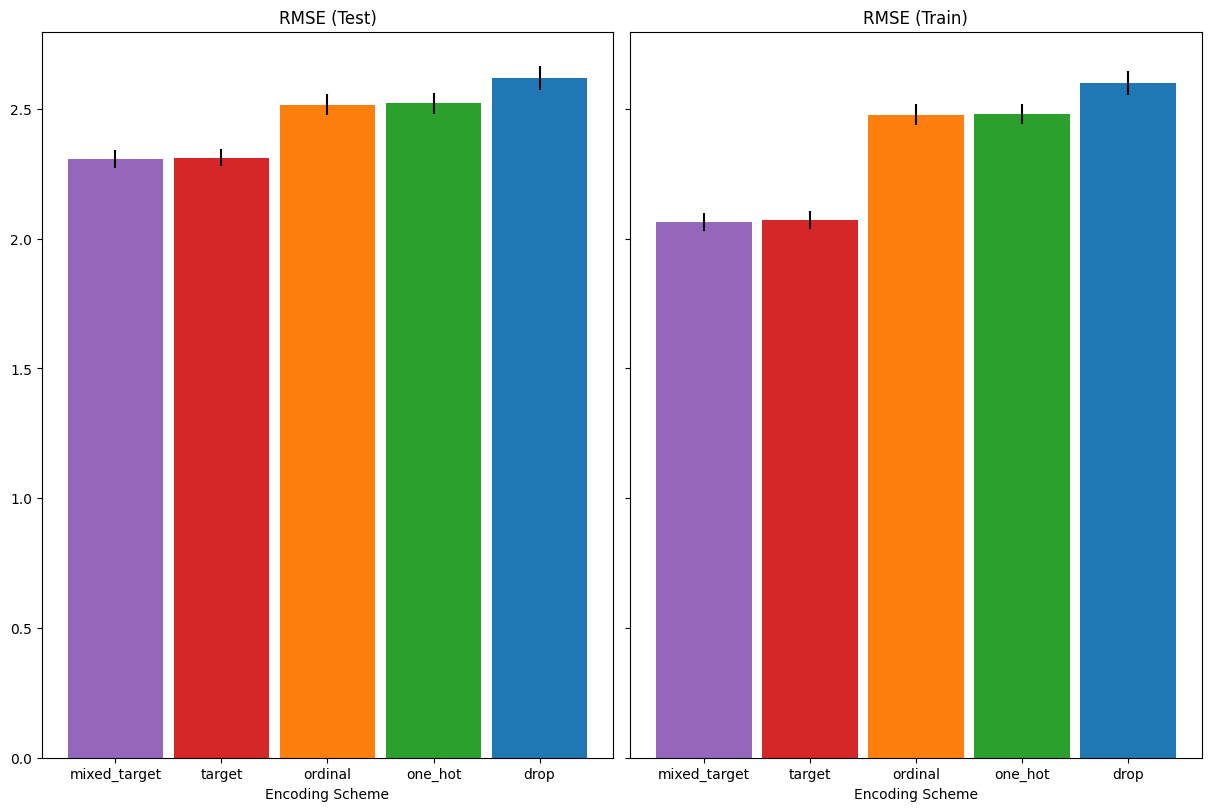

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = (
    pd.DataFrame(results).set_index("preprocessor").sort_values("rmse_test_mean")
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), sharey=True, constrained_layout=True
)
xticks = range(len(results_df))
name_to_color = dict(
    zip((r["preprocessor"] for r in results), ["C0", "C1", "C2", "C3", "C4"])
)

for subset, ax in zip(["test", "train"], [ax1, ax2]):
    mean, std = f"rmse_{subset}_mean", f"rmse_{subset}_std"
    data = results_df[[mean, std]].sort_values(mean)
    ax.bar(
        x=xticks,
        height=data[mean],
        yerr=data[std],
        width=0.9,
        color=[name_to_color[name] for name in data.index],
    )
    ax.set(
        title=f"RMSE ({subset.title()})",
        xlabel="Encoding Scheme",
        xticks=xticks,
        xticklabels=data.index,
    )

When evaluating the predictive performance on the test set, dropping the
categories perform the worst and the target encoders performs the best. This
can be explained as follows:

- Dropping the categorical features makes the pipeline less expressive and
  underfitting as a result;
- Due to the high cardinality and to reduce the training time, the one-hot
  encoding scheme uses `max_categories=20` which prevents the features from
  expanding too much, which can result in underfitting.
- If we had not set `max_categories=20`, the one-hot encoding scheme would have
  likely made the pipeline overfitting as the number of features explodes with rare
  category occurrences that are correlated with the target by chance (on the training
  set only);
- The ordinal encoding imposes an arbitrary order to the features which are then
  treated as numerical values by the
  :class:`~sklearn.ensemble.HistGradientBoostingRegressor`. Since this
  model groups numerical features in 256 bins per feature, many unrelated categories
  can be grouped together and as a result overall pipeline can underfit;
- When using the target encoder, the same binning happens, but since the encoded
  values are statistically ordered by marginal association with the target variable,
  the binning use by the :class:`~sklearn.ensemble.HistGradientBoostingRegressor`
  makes sense and leads to good results: the combination of smoothed target
  encoding and binning works as a good regularizing strategy against
  overfitting while not limiting the expressiveness of the pipeline too much.

